# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

# 需要安装pillow

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

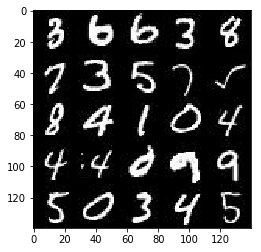

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

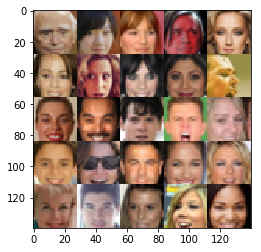

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None,image_width, image_height, image_channels], name = "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32,None, name='learning_rate')  # 不能写 [None,]

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # 定义卷积函数简化代码
    # 激活函数 leaky_relu
    leaky_relu = lambda x: tf.maximum(alpha*x, x)
    
    # 卷积
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, padding='same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
    
    #
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = conv(images, 64, False)
        x2 = conv(x1, 128)
        x3 = conv(x2, 256)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7*7*512
        
        # 7*7*256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # 14*14*128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,2, 'same')
        out = tf.tanh(logits)
    
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.8):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*alpha))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # 获取weights bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # 优化
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # 运行优化器
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps%10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch(批次) {}...".format(steps),
                          "Discriminator Loss(辨别器损失): {:.4f}...".format(train_loss_d),
                          "Generator Loss(生成器损失): {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                    
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Batch(批次) 10... Discriminator Loss(辨别器损失): 4.0585... Generator Loss(生成器损失): 0.0400
Epoch 1/2... Batch(批次) 20... Discriminator Loss(辨别器损失): 2.4132... Generator Loss(生成器损失): 13.3652
Epoch 1/2... Batch(批次) 30... Discriminator Loss(辨别器损失): 0.6545... Generator Loss(生成器损失): 2.7264
Epoch 1/2... Batch(批次) 40... Discriminator Loss(辨别器损失): 0.6186... Generator Loss(生成器损失): 3.1034
Epoch 1/2... Batch(批次) 50... Discriminator Loss(辨别器损失): 0.7436... Generator Loss(生成器损失): 2.7396
Epoch 1/2... Batch(批次) 60... Discriminator Loss(辨别器损失): 0.6415... Generator Loss(生成器损失): 2.7622
Epoch 1/2... Batch(批次) 70... Discriminator Loss(辨别器损失): 0.7091... Generator Loss(生成器损失): 2.3533
Epoch 1/2... Batch(批次) 80... Discriminator Loss(辨别器损失): 0.6330... Generator Loss(生成器损失): 2.4750
Epoch 1/2... Batch(批次) 90... Discriminator Loss(辨别器损失): 0.9958... Generator Loss(生成器损失): 2.9360
Epoch 1/2... Batch(批次) 100... Discriminator Loss(辨别器损失): 0.9574... Generator Loss(生成器损失): 1.6535


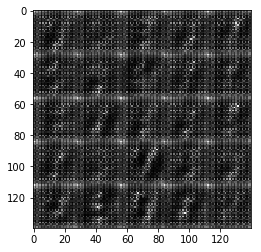

Epoch 1/2... Batch(批次) 110... Discriminator Loss(辨别器损失): 1.2021... Generator Loss(生成器损失): 0.9912
Epoch 1/2... Batch(批次) 120... Discriminator Loss(辨别器损失): 0.9205... Generator Loss(生成器损失): 1.7284
Epoch 1/2... Batch(批次) 130... Discriminator Loss(辨别器损失): 1.1643... Generator Loss(生成器损失): 1.1362
Epoch 1/2... Batch(批次) 140... Discriminator Loss(辨别器损失): 1.4593... Generator Loss(生成器损失): 2.8888
Epoch 1/2... Batch(批次) 150... Discriminator Loss(辨别器损失): 1.1725... Generator Loss(生成器损失): 1.3847
Epoch 1/2... Batch(批次) 160... Discriminator Loss(辨别器损失): 1.1206... Generator Loss(生成器损失): 1.5875
Epoch 1/2... Batch(批次) 170... Discriminator Loss(辨别器损失): 1.1849... Generator Loss(生成器损失): 1.0262
Epoch 1/2... Batch(批次) 180... Discriminator Loss(辨别器损失): 1.3864... Generator Loss(生成器损失): 0.7232
Epoch 1/2... Batch(批次) 190... Discriminator Loss(辨别器损失): 1.2894... Generator Loss(生成器损失): 0.8367
Epoch 1/2... Batch(批次) 200... Discriminator Loss(辨别器损失): 1.1101... Generator Loss(生成器损失): 1.4061


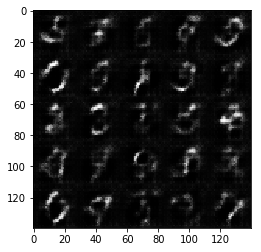

Epoch 1/2... Batch(批次) 210... Discriminator Loss(辨别器损失): 1.3199... Generator Loss(生成器损失): 0.7446
Epoch 1/2... Batch(批次) 220... Discriminator Loss(辨别器损失): 1.2469... Generator Loss(生成器损失): 0.7797
Epoch 1/2... Batch(批次) 230... Discriminator Loss(辨别器损失): 1.3413... Generator Loss(生成器损失): 0.7722
Epoch 1/2... Batch(批次) 240... Discriminator Loss(辨别器损失): 1.4509... Generator Loss(生成器损失): 0.6124
Epoch 1/2... Batch(批次) 250... Discriminator Loss(辨别器损失): 1.1515... Generator Loss(生成器损失): 1.0513
Epoch 1/2... Batch(批次) 260... Discriminator Loss(辨别器损失): 1.4269... Generator Loss(生成器损失): 1.9417
Epoch 1/2... Batch(批次) 270... Discriminator Loss(辨别器损失): 1.1365... Generator Loss(生成器损失): 1.3264
Epoch 1/2... Batch(批次) 280... Discriminator Loss(辨别器损失): 1.2263... Generator Loss(生成器损失): 0.8380
Epoch 1/2... Batch(批次) 290... Discriminator Loss(辨别器损失): 1.7553... Generator Loss(生成器损失): 0.4124
Epoch 1/2... Batch(批次) 300... Discriminator Loss(辨别器损失): 1.2618... Generator Loss(生成器损失): 0.8140


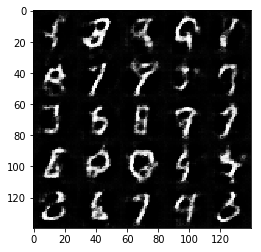

Epoch 1/2... Batch(批次) 310... Discriminator Loss(辨别器损失): 1.1438... Generator Loss(生成器损失): 1.4235
Epoch 1/2... Batch(批次) 320... Discriminator Loss(辨别器损失): 1.2955... Generator Loss(生成器损失): 1.4724
Epoch 1/2... Batch(批次) 330... Discriminator Loss(辨别器损失): 1.1310... Generator Loss(生成器损失): 1.1403
Epoch 1/2... Batch(批次) 340... Discriminator Loss(辨别器损失): 1.1596... Generator Loss(生成器损失): 1.1112
Epoch 1/2... Batch(批次) 350... Discriminator Loss(辨别器损失): 1.1989... Generator Loss(生成器损失): 1.0290
Epoch 1/2... Batch(批次) 360... Discriminator Loss(辨别器损失): 1.2189... Generator Loss(生成器损失): 1.4173
Epoch 1/2... Batch(批次) 370... Discriminator Loss(辨别器损失): 1.2480... Generator Loss(生成器损失): 0.8302
Epoch 1/2... Batch(批次) 380... Discriminator Loss(辨别器损失): 1.1789... Generator Loss(生成器损失): 0.9779
Epoch 1/2... Batch(批次) 390... Discriminator Loss(辨别器损失): 1.2274... Generator Loss(生成器损失): 0.9427
Epoch 1/2... Batch(批次) 400... Discriminator Loss(辨别器损失): 1.1692... Generator Loss(生成器损失): 0.9139


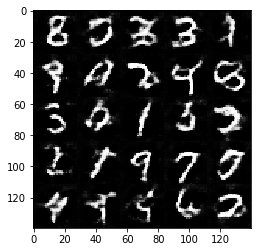

Epoch 1/2... Batch(批次) 410... Discriminator Loss(辨别器损失): 1.2796... Generator Loss(生成器损失): 0.7355
Epoch 1/2... Batch(批次) 420... Discriminator Loss(辨别器损失): 1.1592... Generator Loss(生成器损失): 1.0549
Epoch 1/2... Batch(批次) 430... Discriminator Loss(辨别器损失): 1.3260... Generator Loss(生成器损失): 0.6926
Epoch 1/2... Batch(批次) 440... Discriminator Loss(辨别器损失): 1.1113... Generator Loss(生成器损失): 1.4464
Epoch 1/2... Batch(批次) 450... Discriminator Loss(辨别器损失): 1.1358... Generator Loss(生成器损失): 1.1064
Epoch 1/2... Batch(批次) 460... Discriminator Loss(辨别器损失): 1.1697... Generator Loss(生成器损失): 0.8782
Epoch 2/2... Batch(批次) 470... Discriminator Loss(辨别器损失): 1.1762... Generator Loss(生成器损失): 1.3716
Epoch 2/2... Batch(批次) 480... Discriminator Loss(辨别器损失): 1.1926... Generator Loss(生成器损失): 1.0578
Epoch 2/2... Batch(批次) 490... Discriminator Loss(辨别器损失): 1.1355... Generator Loss(生成器损失): 1.0609
Epoch 2/2... Batch(批次) 500... Discriminator Loss(辨别器损失): 1.1646... Generator Loss(生成器损失): 1.0886


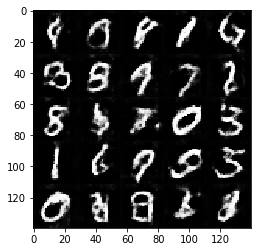

Epoch 2/2... Batch(批次) 510... Discriminator Loss(辨别器损失): 1.3642... Generator Loss(生成器损失): 0.6424
Epoch 2/2... Batch(批次) 520... Discriminator Loss(辨别器损失): 1.1581... Generator Loss(生成器损失): 0.9923
Epoch 2/2... Batch(批次) 530... Discriminator Loss(辨别器损失): 1.1603... Generator Loss(生成器损失): 1.0791
Epoch 2/2... Batch(批次) 540... Discriminator Loss(辨别器损失): 1.3799... Generator Loss(生成器损失): 1.8663
Epoch 2/2... Batch(批次) 550... Discriminator Loss(辨别器损失): 1.2205... Generator Loss(生成器损失): 0.9829
Epoch 2/2... Batch(批次) 560... Discriminator Loss(辨别器损失): 1.1938... Generator Loss(生成器损失): 1.4617
Epoch 2/2... Batch(批次) 570... Discriminator Loss(辨别器损失): 1.1502... Generator Loss(生成器损失): 1.0203
Epoch 2/2... Batch(批次) 580... Discriminator Loss(辨别器损失): 1.2228... Generator Loss(生成器损失): 0.8313
Epoch 2/2... Batch(批次) 590... Discriminator Loss(辨别器损失): 1.1714... Generator Loss(生成器损失): 1.4838
Epoch 2/2... Batch(批次) 600... Discriminator Loss(辨别器损失): 1.1474... Generator Loss(生成器损失): 1.1351


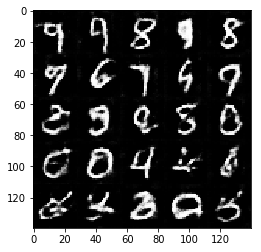

Epoch 2/2... Batch(批次) 610... Discriminator Loss(辨别器损失): 1.2873... Generator Loss(生成器损失): 1.6247
Epoch 2/2... Batch(批次) 620... Discriminator Loss(辨别器损失): 1.1657... Generator Loss(生成器损失): 1.0700
Epoch 2/2... Batch(批次) 630... Discriminator Loss(辨别器损失): 1.1495... Generator Loss(生成器损失): 1.2528
Epoch 2/2... Batch(批次) 640... Discriminator Loss(辨别器损失): 1.2253... Generator Loss(生成器损失): 1.5025
Epoch 2/2... Batch(批次) 650... Discriminator Loss(辨别器损失): 1.3124... Generator Loss(生成器损失): 0.7031
Epoch 2/2... Batch(批次) 660... Discriminator Loss(辨别器损失): 1.1832... Generator Loss(生成器损失): 0.9030
Epoch 2/2... Batch(批次) 670... Discriminator Loss(辨别器损失): 1.1664... Generator Loss(生成器损失): 1.3384
Epoch 2/2... Batch(批次) 680... Discriminator Loss(辨别器损失): 1.3102... Generator Loss(生成器损失): 0.7053
Epoch 2/2... Batch(批次) 690... Discriminator Loss(辨别器损失): 1.3446... Generator Loss(生成器损失): 0.6781
Epoch 2/2... Batch(批次) 700... Discriminator Loss(辨别器损失): 1.1508... Generator Loss(生成器损失): 1.1630


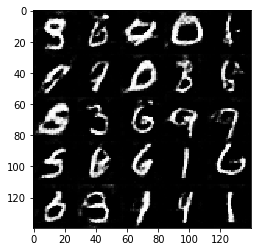

Epoch 2/2... Batch(批次) 710... Discriminator Loss(辨别器损失): 1.1204... Generator Loss(生成器损失): 1.2120
Epoch 2/2... Batch(批次) 720... Discriminator Loss(辨别器损失): 1.2229... Generator Loss(生成器损失): 0.8292
Epoch 2/2... Batch(批次) 730... Discriminator Loss(辨别器损失): 1.3580... Generator Loss(生成器损失): 0.6516
Epoch 2/2... Batch(批次) 740... Discriminator Loss(辨别器损失): 1.2288... Generator Loss(生成器损失): 0.8247
Epoch 2/2... Batch(批次) 750... Discriminator Loss(辨别器损失): 1.1660... Generator Loss(生成器损失): 1.1957
Epoch 2/2... Batch(批次) 760... Discriminator Loss(辨别器损失): 1.7069... Generator Loss(生成器损失): 0.4961
Epoch 2/2... Batch(批次) 770... Discriminator Loss(辨别器损失): 1.0974... Generator Loss(生成器损失): 1.0132
Epoch 2/2... Batch(批次) 780... Discriminator Loss(辨别器损失): 1.2698... Generator Loss(生成器损失): 0.7518
Epoch 2/2... Batch(批次) 790... Discriminator Loss(辨别器损失): 1.4091... Generator Loss(生成器损失): 2.1193
Epoch 2/2... Batch(批次) 800... Discriminator Loss(辨别器损失): 1.2406... Generator Loss(生成器损失): 0.7879


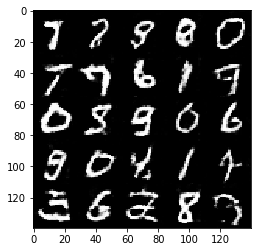

Epoch 2/2... Batch(批次) 810... Discriminator Loss(辨别器损失): 1.1394... Generator Loss(生成器损失): 1.0175
Epoch 2/2... Batch(批次) 820... Discriminator Loss(辨别器损失): 1.3782... Generator Loss(生成器损失): 0.6581
Epoch 2/2... Batch(批次) 830... Discriminator Loss(辨别器损失): 1.1407... Generator Loss(生成器损失): 1.1335
Epoch 2/2... Batch(批次) 840... Discriminator Loss(辨别器损失): 1.1298... Generator Loss(生成器损失): 1.0476
Epoch 2/2... Batch(批次) 850... Discriminator Loss(辨别器损失): 1.1129... Generator Loss(生成器损失): 1.1947
Epoch 2/2... Batch(批次) 860... Discriminator Loss(辨别器损失): 1.1613... Generator Loss(生成器损失): 1.8162
Epoch 2/2... Batch(批次) 870... Discriminator Loss(辨别器损失): 1.1418... Generator Loss(生成器损失): 1.3335
Epoch 2/2... Batch(批次) 880... Discriminator Loss(辨别器损失): 1.3159... Generator Loss(生成器损失): 0.8427
Epoch 2/2... Batch(批次) 890... Discriminator Loss(辨别器损失): 1.1675... Generator Loss(生成器损失): 0.9267
Epoch 2/2... Batch(批次) 900... Discriminator Loss(辨别器损失): 1.1422... Generator Loss(生成器损失): 1.4675


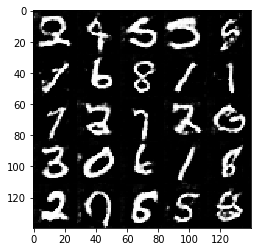

Epoch 2/2... Batch(批次) 910... Discriminator Loss(辨别器损失): 1.2503... Generator Loss(生成器损失): 0.7601
Epoch 2/2... Batch(批次) 920... Discriminator Loss(辨别器损失): 1.6006... Generator Loss(生成器损失): 0.4916
Epoch 2/2... Batch(批次) 930... Discriminator Loss(辨别器损失): 1.2415... Generator Loss(生成器损失): 1.2114


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Batch(批次) 10... Discriminator Loss(辨别器损失): 1.5355... Generator Loss(生成器损失): 0.6268
Epoch 1/1... Batch(批次) 20... Discriminator Loss(辨别器损失): 0.8481... Generator Loss(生成器损失): 3.8333
Epoch 1/1... Batch(批次) 30... Discriminator Loss(辨别器损失): 0.7341... Generator Loss(生成器损失): 3.1897
Epoch 1/1... Batch(批次) 40... Discriminator Loss(辨别器损失): 0.7725... Generator Loss(生成器损失): 2.2286
Epoch 1/1... Batch(批次) 50... Discriminator Loss(辨别器损失): 0.7304... Generator Loss(生成器损失): 2.1244
Epoch 1/1... Batch(批次) 60... Discriminator Loss(辨别器损失): 0.6421... Generator Loss(生成器损失): 2.6142
Epoch 1/1... Batch(批次) 70... Discriminator Loss(辨别器损失): 0.6571... Generator Loss(生成器损失): 2.5114
Epoch 1/1... Batch(批次) 80... Discriminator Loss(辨别器损失): 0.8940... Generator Loss(生成器损失): 8.0965
Epoch 1/1... Batch(批次) 90... Discriminator Loss(辨别器损失): 0.7621... Generator Loss(生成器损失): 4.3111
Epoch 1/1... Batch(批次) 100... Discriminator Loss(辨别器损失): 0.8619... Generator Loss(生成器损失): 1.9307


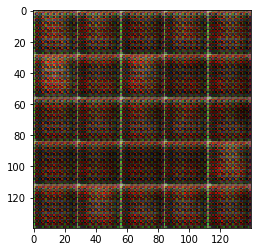

Epoch 1/1... Batch(批次) 110... Discriminator Loss(辨别器损失): 0.8894... Generator Loss(生成器损失): 2.5811
Epoch 1/1... Batch(批次) 120... Discriminator Loss(辨别器损失): 1.0718... Generator Loss(生成器损失): 2.7555
Epoch 1/1... Batch(批次) 130... Discriminator Loss(辨别器损失): 0.9632... Generator Loss(生成器损失): 1.3535
Epoch 1/1... Batch(批次) 140... Discriminator Loss(辨别器损失): 0.9543... Generator Loss(生成器损失): 1.2663
Epoch 1/1... Batch(批次) 150... Discriminator Loss(辨别器损失): 1.5162... Generator Loss(生成器损失): 0.6123
Epoch 1/1... Batch(批次) 160... Discriminator Loss(辨别器损失): 0.8536... Generator Loss(生成器损失): 1.5637
Epoch 1/1... Batch(批次) 170... Discriminator Loss(辨别器损失): 0.9054... Generator Loss(生成器损失): 1.8584
Epoch 1/1... Batch(批次) 180... Discriminator Loss(辨别器损失): 0.9993... Generator Loss(生成器损失): 1.6879
Epoch 1/1... Batch(批次) 190... Discriminator Loss(辨别器损失): 1.2131... Generator Loss(生成器损失): 1.1524
Epoch 1/1... Batch(批次) 200... Discriminator Loss(辨别器损失): 1.1333... Generator Loss(生成器损失): 1.0190


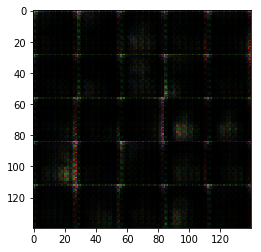

Epoch 1/1... Batch(批次) 210... Discriminator Loss(辨别器损失): 1.0742... Generator Loss(生成器损失): 1.8020
Epoch 1/1... Batch(批次) 220... Discriminator Loss(辨别器损失): 1.0286... Generator Loss(生成器损失): 1.4129
Epoch 1/1... Batch(批次) 230... Discriminator Loss(辨别器损失): 1.0138... Generator Loss(生成器损失): 2.1430
Epoch 1/1... Batch(批次) 240... Discriminator Loss(辨别器损失): 1.5704... Generator Loss(生成器损失): 0.5513
Epoch 1/1... Batch(批次) 250... Discriminator Loss(辨别器损失): 1.1156... Generator Loss(生成器损失): 1.5400
Epoch 1/1... Batch(批次) 260... Discriminator Loss(辨别器损失): 0.9695... Generator Loss(生成器损失): 1.6819
Epoch 1/1... Batch(批次) 270... Discriminator Loss(辨别器损失): 1.2978... Generator Loss(生成器损失): 0.8809
Epoch 1/1... Batch(批次) 280... Discriminator Loss(辨别器损失): 1.0197... Generator Loss(生成器损失): 1.3237
Epoch 1/1... Batch(批次) 290... Discriminator Loss(辨别器损失): 1.0412... Generator Loss(生成器损失): 2.8469
Epoch 1/1... Batch(批次) 300... Discriminator Loss(辨别器损失): 1.0852... Generator Loss(生成器损失): 1.9061


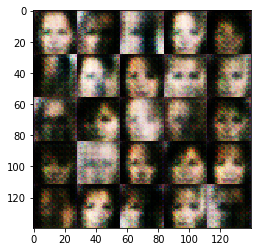

Epoch 1/1... Batch(批次) 310... Discriminator Loss(辨别器损失): 1.2707... Generator Loss(生成器损失): 1.0507
Epoch 1/1... Batch(批次) 320... Discriminator Loss(辨别器损失): 1.1602... Generator Loss(生成器损失): 1.7368
Epoch 1/1... Batch(批次) 330... Discriminator Loss(辨别器损失): 1.1880... Generator Loss(生成器损失): 1.2085
Epoch 1/1... Batch(批次) 340... Discriminator Loss(辨别器损失): 1.3698... Generator Loss(生成器损失): 0.7697
Epoch 1/1... Batch(批次) 350... Discriminator Loss(辨别器损失): 1.2052... Generator Loss(生成器损失): 0.9148
Epoch 1/1... Batch(批次) 360... Discriminator Loss(辨别器损失): 1.2252... Generator Loss(生成器损失): 2.1542
Epoch 1/1... Batch(批次) 370... Discriminator Loss(辨别器损失): 1.1645... Generator Loss(生成器损失): 1.4788
Epoch 1/1... Batch(批次) 380... Discriminator Loss(辨别器损失): 1.2621... Generator Loss(生成器损失): 1.4393
Epoch 1/1... Batch(批次) 390... Discriminator Loss(辨别器损失): 1.2530... Generator Loss(生成器损失): 1.1478
Epoch 1/1... Batch(批次) 400... Discriminator Loss(辨别器损失): 1.2651... Generator Loss(生成器损失): 0.9167


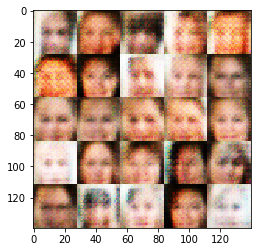

Epoch 1/1... Batch(批次) 410... Discriminator Loss(辨别器损失): 1.2540... Generator Loss(生成器损失): 1.3685
Epoch 1/1... Batch(批次) 420... Discriminator Loss(辨别器损失): 1.2562... Generator Loss(生成器损失): 1.0816
Epoch 1/1... Batch(批次) 430... Discriminator Loss(辨别器损失): 1.1302... Generator Loss(生成器损失): 1.6649
Epoch 1/1... Batch(批次) 440... Discriminator Loss(辨别器损失): 1.2964... Generator Loss(生成器损失): 1.0140
Epoch 1/1... Batch(批次) 450... Discriminator Loss(辨别器损失): 1.2357... Generator Loss(生成器损失): 1.2503
Epoch 1/1... Batch(批次) 460... Discriminator Loss(辨别器损失): 1.2066... Generator Loss(生成器损失): 1.0641
Epoch 1/1... Batch(批次) 470... Discriminator Loss(辨别器损失): 1.1946... Generator Loss(生成器损失): 1.6422
Epoch 1/1... Batch(批次) 480... Discriminator Loss(辨别器损失): 1.0620... Generator Loss(生成器损失): 1.4282
Epoch 1/1... Batch(批次) 490... Discriminator Loss(辨别器损失): 1.1759... Generator Loss(生成器损失): 1.0899
Epoch 1/1... Batch(批次) 500... Discriminator Loss(辨别器损失): 1.3498... Generator Loss(生成器损失): 0.7776


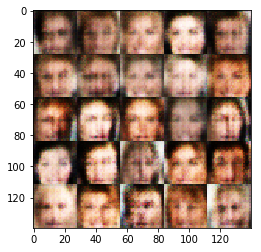

Epoch 1/1... Batch(批次) 510... Discriminator Loss(辨别器损失): 1.1788... Generator Loss(生成器损失): 0.9678
Epoch 1/1... Batch(批次) 520... Discriminator Loss(辨别器损失): 1.2285... Generator Loss(生成器损失): 1.6469
Epoch 1/1... Batch(批次) 530... Discriminator Loss(辨别器损失): 1.1686... Generator Loss(生成器损失): 1.4790
Epoch 1/1... Batch(批次) 540... Discriminator Loss(辨别器损失): 1.1143... Generator Loss(生成器损失): 1.5364
Epoch 1/1... Batch(批次) 550... Discriminator Loss(辨别器损失): 1.2819... Generator Loss(生成器损失): 0.8468
Epoch 1/1... Batch(批次) 560... Discriminator Loss(辨别器损失): 1.2507... Generator Loss(生成器损失): 0.8164
Epoch 1/1... Batch(批次) 570... Discriminator Loss(辨别器损失): 1.3980... Generator Loss(生成器损失): 0.6102
Epoch 1/1... Batch(批次) 580... Discriminator Loss(辨别器损失): 1.2667... Generator Loss(生成器损失): 0.9512
Epoch 1/1... Batch(批次) 590... Discriminator Loss(辨别器损失): 1.0972... Generator Loss(生成器损失): 1.2735
Epoch 1/1... Batch(批次) 600... Discriminator Loss(辨别器损失): 1.5861... Generator Loss(生成器损失): 0.5159


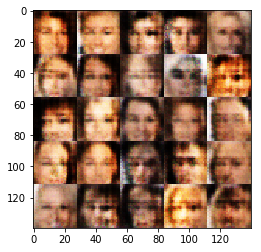

Epoch 1/1... Batch(批次) 610... Discriminator Loss(辨别器损失): 1.2826... Generator Loss(生成器损失): 0.8201
Epoch 1/1... Batch(批次) 620... Discriminator Loss(辨别器损失): 1.3201... Generator Loss(生成器损失): 1.0694
Epoch 1/1... Batch(批次) 630... Discriminator Loss(辨别器损失): 1.1520... Generator Loss(生成器损失): 1.5337
Epoch 1/1... Batch(批次) 640... Discriminator Loss(辨别器损失): 0.9533... Generator Loss(生成器损失): 1.2253
Epoch 1/1... Batch(批次) 650... Discriminator Loss(辨别器损失): 1.2323... Generator Loss(生成器损失): 1.0158
Epoch 1/1... Batch(批次) 660... Discriminator Loss(辨别器损失): 1.1353... Generator Loss(生成器损失): 1.4114
Epoch 1/1... Batch(批次) 670... Discriminator Loss(辨别器损失): 1.0493... Generator Loss(生成器损失): 1.0988
Epoch 1/1... Batch(批次) 680... Discriminator Loss(辨别器损失): 1.0008... Generator Loss(生成器损失): 1.7511
Epoch 1/1... Batch(批次) 690... Discriminator Loss(辨别器损失): 1.2334... Generator Loss(生成器损失): 0.8807
Epoch 1/1... Batch(批次) 700... Discriminator Loss(辨别器损失): 0.9040... Generator Loss(生成器损失): 1.8069


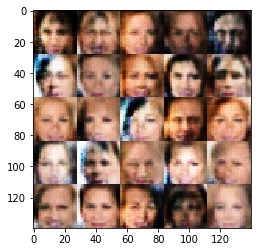

Epoch 1/1... Batch(批次) 710... Discriminator Loss(辨别器损失): 1.1758... Generator Loss(生成器损失): 3.1995
Epoch 1/1... Batch(批次) 720... Discriminator Loss(辨别器损失): 1.1995... Generator Loss(生成器损失): 1.9957
Epoch 1/1... Batch(批次) 730... Discriminator Loss(辨别器损失): 1.0101... Generator Loss(生成器损失): 2.1968
Epoch 1/1... Batch(批次) 740... Discriminator Loss(辨别器损失): 0.9719... Generator Loss(生成器损失): 1.3300
Epoch 1/1... Batch(批次) 750... Discriminator Loss(辨别器损失): 1.0547... Generator Loss(生成器损失): 1.3035
Epoch 1/1... Batch(批次) 760... Discriminator Loss(辨别器损失): 0.9626... Generator Loss(生成器损失): 1.5086
Epoch 1/1... Batch(批次) 770... Discriminator Loss(辨别器损失): 1.0128... Generator Loss(生成器损失): 1.0742
Epoch 1/1... Batch(批次) 780... Discriminator Loss(辨别器损失): 1.1972... Generator Loss(生成器损失): 2.2221
Epoch 1/1... Batch(批次) 790... Discriminator Loss(辨别器损失): 0.9981... Generator Loss(生成器损失): 1.1659
Epoch 1/1... Batch(批次) 800... Discriminator Loss(辨别器损失): 2.2072... Generator Loss(生成器损失): 2.9878


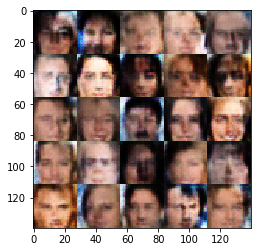

Epoch 1/1... Batch(批次) 810... Discriminator Loss(辨别器损失): 0.9382... Generator Loss(生成器损失): 1.8239
Epoch 1/1... Batch(批次) 820... Discriminator Loss(辨别器损失): 0.8457... Generator Loss(生成器损失): 2.4265
Epoch 1/1... Batch(批次) 830... Discriminator Loss(辨别器损失): 1.0909... Generator Loss(生成器损失): 3.3047
Epoch 1/1... Batch(批次) 840... Discriminator Loss(辨别器损失): 1.2405... Generator Loss(生成器损失): 1.7076
Epoch 1/1... Batch(批次) 850... Discriminator Loss(辨别器损失): 0.9309... Generator Loss(生成器损失): 1.5348
Epoch 1/1... Batch(批次) 860... Discriminator Loss(辨别器损失): 0.9426... Generator Loss(生成器损失): 1.4868
Epoch 1/1... Batch(批次) 870... Discriminator Loss(辨别器损失): 0.9490... Generator Loss(生成器损失): 1.4934
Epoch 1/1... Batch(批次) 880... Discriminator Loss(辨别器损失): 1.3932... Generator Loss(生成器损失): 0.6236
Epoch 1/1... Batch(批次) 890... Discriminator Loss(辨别器损失): 1.2542... Generator Loss(生成器损失): 0.7326
Epoch 1/1... Batch(批次) 900... Discriminator Loss(辨别器损失): 1.4200... Generator Loss(生成器损失): 0.6095


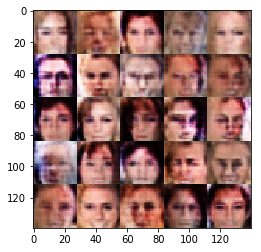

Epoch 1/1... Batch(批次) 910... Discriminator Loss(辨别器损失): 1.3607... Generator Loss(生成器损失): 1.6498
Epoch 1/1... Batch(批次) 920... Discriminator Loss(辨别器损失): 1.6997... Generator Loss(生成器损失): 0.4356
Epoch 1/1... Batch(批次) 930... Discriminator Loss(辨别器损失): 1.1192... Generator Loss(生成器损失): 1.4680
Epoch 1/1... Batch(批次) 940... Discriminator Loss(辨别器损失): 0.8517... Generator Loss(生成器损失): 1.7379
Epoch 1/1... Batch(批次) 950... Discriminator Loss(辨别器损失): 1.0998... Generator Loss(生成器损失): 1.1188
Epoch 1/1... Batch(批次) 960... Discriminator Loss(辨别器损失): 1.0502... Generator Loss(生成器损失): 1.2522
Epoch 1/1... Batch(批次) 970... Discriminator Loss(辨别器损失): 1.1886... Generator Loss(生成器损失): 0.9139
Epoch 1/1... Batch(批次) 980... Discriminator Loss(辨别器损失): 1.3132... Generator Loss(生成器损失): 0.6917
Epoch 1/1... Batch(批次) 990... Discriminator Loss(辨别器损失): 1.0601... Generator Loss(生成器损失): 1.0465
Epoch 1/1... Batch(批次) 1000... Discriminator Loss(辨别器损失): 0.6771... Generator Loss(生成器损失): 2.3109


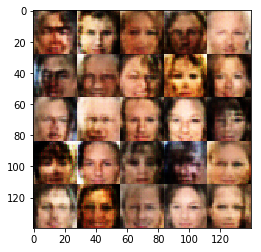

Epoch 1/1... Batch(批次) 1010... Discriminator Loss(辨别器损失): 1.3119... Generator Loss(生成器损失): 0.9078
Epoch 1/1... Batch(批次) 1020... Discriminator Loss(辨别器损失): 0.8460... Generator Loss(生成器损失): 1.6725
Epoch 1/1... Batch(批次) 1030... Discriminator Loss(辨别器损失): 0.9955... Generator Loss(生成器损失): 1.2456
Epoch 1/1... Batch(批次) 1040... Discriminator Loss(辨别器损失): 1.5023... Generator Loss(生成器损失): 2.1209
Epoch 1/1... Batch(批次) 1050... Discriminator Loss(辨别器损失): 1.6520... Generator Loss(生成器损失): 0.4517
Epoch 1/1... Batch(批次) 1060... Discriminator Loss(辨别器损失): 0.7666... Generator Loss(生成器损失): 1.9089
Epoch 1/1... Batch(批次) 1070... Discriminator Loss(辨别器损失): 1.3075... Generator Loss(生成器损失): 2.7099
Epoch 1/1... Batch(批次) 1080... Discriminator Loss(辨别器损失): 1.3401... Generator Loss(生成器损失): 1.9393
Epoch 1/1... Batch(批次) 1090... Discriminator Loss(辨别器损失): 0.8483... Generator Loss(生成器损失): 1.4153
Epoch 1/1... Batch(批次) 1100... Discriminator Loss(辨别器损失): 1.3346... Generator Loss(生成器损失): 0.7157


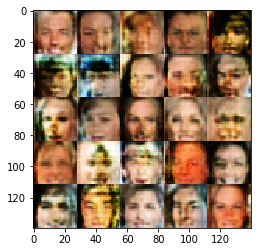

Epoch 1/1... Batch(批次) 1110... Discriminator Loss(辨别器损失): 1.2950... Generator Loss(生成器损失): 0.8827
Epoch 1/1... Batch(批次) 1120... Discriminator Loss(辨别器损失): 1.1537... Generator Loss(生成器损失): 1.1467
Epoch 1/1... Batch(批次) 1130... Discriminator Loss(辨别器损失): 1.0503... Generator Loss(生成器损失): 1.2516
Epoch 1/1... Batch(批次) 1140... Discriminator Loss(辨别器损失): 1.2599... Generator Loss(生成器损失): 2.4015
Epoch 1/1... Batch(批次) 1150... Discriminator Loss(辨别器损失): 1.2374... Generator Loss(生成器损失): 2.6612
Epoch 1/1... Batch(批次) 1160... Discriminator Loss(辨别器损失): 1.1946... Generator Loss(生成器损失): 1.2891
Epoch 1/1... Batch(批次) 1170... Discriminator Loss(辨别器损失): 1.1908... Generator Loss(生成器损失): 1.1074
Epoch 1/1... Batch(批次) 1180... Discriminator Loss(辨别器损失): 0.9119... Generator Loss(生成器损失): 1.3207
Epoch 1/1... Batch(批次) 1190... Discriminator Loss(辨别器损失): 1.0535... Generator Loss(生成器损失): 0.9854
Epoch 1/1... Batch(批次) 1200... Discriminator Loss(辨别器损失): 1.4039... Generator Loss(生成器损失): 0.5886


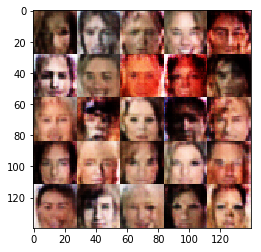

Epoch 1/1... Batch(批次) 1210... Discriminator Loss(辨别器损失): 1.2713... Generator Loss(生成器损失): 1.0093
Epoch 1/1... Batch(批次) 1220... Discriminator Loss(辨别器损失): 1.1942... Generator Loss(生成器损失): 1.1622
Epoch 1/1... Batch(批次) 1230... Discriminator Loss(辨别器损失): 1.0522... Generator Loss(生成器损失): 1.0479
Epoch 1/1... Batch(批次) 1240... Discriminator Loss(辨别器损失): 0.9088... Generator Loss(生成器损失): 1.5424
Epoch 1/1... Batch(批次) 1250... Discriminator Loss(辨别器损失): 1.5777... Generator Loss(生成器损失): 0.4753
Epoch 1/1... Batch(批次) 1260... Discriminator Loss(辨别器损失): 1.1957... Generator Loss(生成器损失): 1.4434
Epoch 1/1... Batch(批次) 1270... Discriminator Loss(辨别器损失): 1.0573... Generator Loss(生成器损失): 1.1182
Epoch 1/1... Batch(批次) 1280... Discriminator Loss(辨别器损失): 1.1397... Generator Loss(生成器损失): 0.8874
Epoch 1/1... Batch(批次) 1290... Discriminator Loss(辨别器损失): 1.4991... Generator Loss(生成器损失): 0.5146
Epoch 1/1... Batch(批次) 1300... Discriminator Loss(辨别器损失): 1.2285... Generator Loss(生成器损失): 0.9203


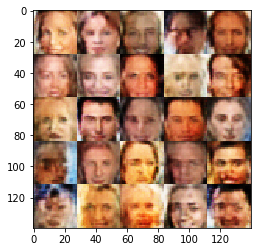

Epoch 1/1... Batch(批次) 1310... Discriminator Loss(辨别器损失): 1.3097... Generator Loss(生成器损失): 0.7768
Epoch 1/1... Batch(批次) 1320... Discriminator Loss(辨别器损失): 1.7580... Generator Loss(生成器损失): 2.5694
Epoch 1/1... Batch(批次) 1330... Discriminator Loss(辨别器损失): 0.9980... Generator Loss(生成器损失): 1.3842
Epoch 1/1... Batch(批次) 1340... Discriminator Loss(辨别器损失): 0.8719... Generator Loss(生成器损失): 1.6182
Epoch 1/1... Batch(批次) 1350... Discriminator Loss(辨别器损失): 0.6769... Generator Loss(生成器损失): 2.2381
Epoch 1/1... Batch(批次) 1360... Discriminator Loss(辨别器损失): 1.1651... Generator Loss(生成器损失): 1.1768
Epoch 1/1... Batch(批次) 1370... Discriminator Loss(辨别器损失): 1.2094... Generator Loss(生成器损失): 0.8444
Epoch 1/1... Batch(批次) 1380... Discriminator Loss(辨别器损失): 1.2603... Generator Loss(生成器损失): 0.7889
Epoch 1/1... Batch(批次) 1390... Discriminator Loss(辨别器损失): 1.1023... Generator Loss(生成器损失): 1.6766
Epoch 1/1... Batch(批次) 1400... Discriminator Loss(辨别器损失): 1.2832... Generator Loss(生成器损失): 0.6990


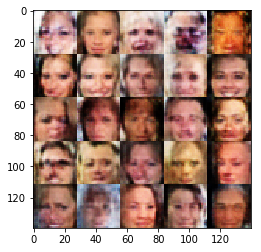

Epoch 1/1... Batch(批次) 1410... Discriminator Loss(辨别器损失): 0.8557... Generator Loss(生成器损失): 1.3759
Epoch 1/1... Batch(批次) 1420... Discriminator Loss(辨别器损失): 0.7589... Generator Loss(生成器损失): 1.7055
Epoch 1/1... Batch(批次) 1430... Discriminator Loss(辨别器损失): 1.5613... Generator Loss(生成器损失): 0.5104
Epoch 1/1... Batch(批次) 1440... Discriminator Loss(辨别器损失): 1.1482... Generator Loss(生成器损失): 1.0918
Epoch 1/1... Batch(批次) 1450... Discriminator Loss(辨别器损失): 1.3015... Generator Loss(生成器损失): 0.8973
Epoch 1/1... Batch(批次) 1460... Discriminator Loss(辨别器损失): 1.2486... Generator Loss(生成器损失): 1.3291
Epoch 1/1... Batch(批次) 1470... Discriminator Loss(辨别器损失): 1.1463... Generator Loss(生成器损失): 1.1653
Epoch 1/1... Batch(批次) 1480... Discriminator Loss(辨别器损失): 1.1563... Generator Loss(生成器损失): 1.5826
Epoch 1/1... Batch(批次) 1490... Discriminator Loss(辨别器损失): 1.2888... Generator Loss(生成器损失): 0.9623
Epoch 1/1... Batch(批次) 1500... Discriminator Loss(辨别器损失): 1.2102... Generator Loss(生成器损失): 1.0196


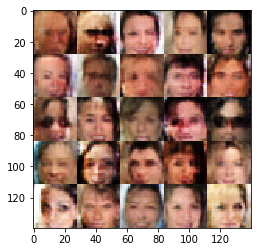

Epoch 1/1... Batch(批次) 1510... Discriminator Loss(辨别器损失): 1.1233... Generator Loss(生成器损失): 0.9752
Epoch 1/1... Batch(批次) 1520... Discriminator Loss(辨别器损失): 1.3192... Generator Loss(生成器损失): 0.7599
Epoch 1/1... Batch(批次) 1530... Discriminator Loss(辨别器损失): 1.4807... Generator Loss(生成器损失): 0.5488
Epoch 1/1... Batch(批次) 1540... Discriminator Loss(辨别器损失): 1.1965... Generator Loss(生成器损失): 0.8797
Epoch 1/1... Batch(批次) 1550... Discriminator Loss(辨别器损失): 1.1201... Generator Loss(生成器损失): 0.9368
Epoch 1/1... Batch(批次) 1560... Discriminator Loss(辨别器损失): 0.8975... Generator Loss(生成器损失): 1.4419
Epoch 1/1... Batch(批次) 1570... Discriminator Loss(辨别器损失): 1.7436... Generator Loss(生成器损失): 2.7727
Epoch 1/1... Batch(批次) 1580... Discriminator Loss(辨别器损失): 0.7276... Generator Loss(生成器损失): 2.1289


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。